    Let's start by loading the material parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the directory and file for material properties
mydir = os.path.join(os.path.dirname(os.getcwd()), 'polyisobutylene_data')
filename = 'PIB.txt'
filepath = os.path.join(mydir, filename)

# Load the CSV data
data = pd.read_csv(filepath,delimiter='\t')

# Extract G_k and tau_k arrays
tau_k = data.iloc[:, 0].to_numpy()
G_k = data.iloc[:, 1].to_numpy()

# Creating the DataFrame
df = pd.DataFrame({'tau_k': tau_k,'G_k': G_k })

# Sort the DataFrame by tau_k in ascending order
pib = df.sort_values(by='tau_k')

# Print sorted DataFrame
print(pib)


           tau_k           G_k
0   1.363659e-11  5.615300e+07
1   5.653602e-11  1.294981e+08
2   2.339704e-10  3.214060e+08
3   1.166073e-09  4.131962e+08
4   4.851911e-09  8.227107e+08
5   2.249711e-08  6.314586e+08
6   9.652457e-08  3.606929e+08
7   3.832186e-07  1.533294e+08
8   1.671136e-06  4.521882e+07
9   7.195991e-06  2.230038e+07
10  2.888032e-05  6.100996e+06
11  1.478849e-04  2.606182e+06
12  5.871274e-04  1.107880e+06
13  2.360628e-03  2.816315e+05
14  9.355184e-03  1.288454e+05
15  4.028387e-02  6.354216e+04
16  1.798397e-01  7.212026e+03
17  8.160072e-01  1.336453e+04
18  3.292734e+00  9.275610e+04
19  1.302560e+01  4.566990e+04
20  5.846602e+01  1.315000e+05
21  2.966924e+02  8.110155e+04
22  1.045648e+03  1.389663e+05
23  5.277607e+03  1.068347e+05
24  2.635032e+04  1.276189e+05
25  8.797344e+04  6.263134e+04
26  4.123520e+05  3.093785e+04
27  1.830927e+06  1.384156e-01
28  7.757038e+06  1.322139e-01


Now let's define experimental variables

In [31]:
# User-defined parameters
P = 2**12  # sequence length including zero padded values
M = int(P/10) #non-zero values of the relaxation modulus
Delta_t = tau_k[5]/100.0  # timestep
G_e = 0.0  #equlibrium modulus, for PIB assumed zero

Let's load some useful functions from our library

In [32]:
# Define the directory and file for material properties
mylibdir = os.path.join(os.path.dirname(os.getcwd()), 'lib')
os.chdir(mylibdir)
from lib_nls import Y, X, nls_fit2, g_star,func_g,zero_padding,add_noise,dtft_gt_finite,perform_fft,g_hat,nls_fit,g_maxwell_finite,calculate_g_nu,g_hat_ctft


In [33]:
#Simulate relaxation modulus with and without noise
y_n,tn= g_maxwell_finite(P,M,Delta_t,G_k,tau_k,G_e)

y_n2,tn2 = g_maxwell_finite(M,M,Delta_t,G_k,tau_k,G_e)  #relaxation modulus without zero padding
noise_level = 0.0#5.0e7  # adjust as necessary
y_noise = add_noise(y_n2,noise_level) #noise is added for the simulation trace (added to the non-padded version)
y_noisy = zero_padding(y_noise,P)  #Stress-relaxation for PIB: simulated trace with Gaussian noise


In [34]:
ini_par = {
    'model': func_g,
    'arms': 3,
    'Ge': 0.0,
    'G_i': [10.0e9,1.0e9,1.0e8],  # initial guesses for G1 to G3
    'tau_i': [Delta_t/10.0,Delta_t,Delta_t*10], # initial guesses for tau1 to tau3
    'delta_t':Delta_t,
    'M':M,
    'method_fit':'leastsq'
}

Ge_grel_c, tau_grel_c, G_grel_c, res_grel_c = nls_fit2(tn[1:M],y_noisy[1:M],**ini_par)

In [35]:
print(Ge_grel_c, tau_grel_c, G_grel_c)

285382483.4541865 [7.99911470e-10 5.19415222e-09 3.58758854e-08] [5.56429942e+08 9.46547109e+08 8.43471445e+08]


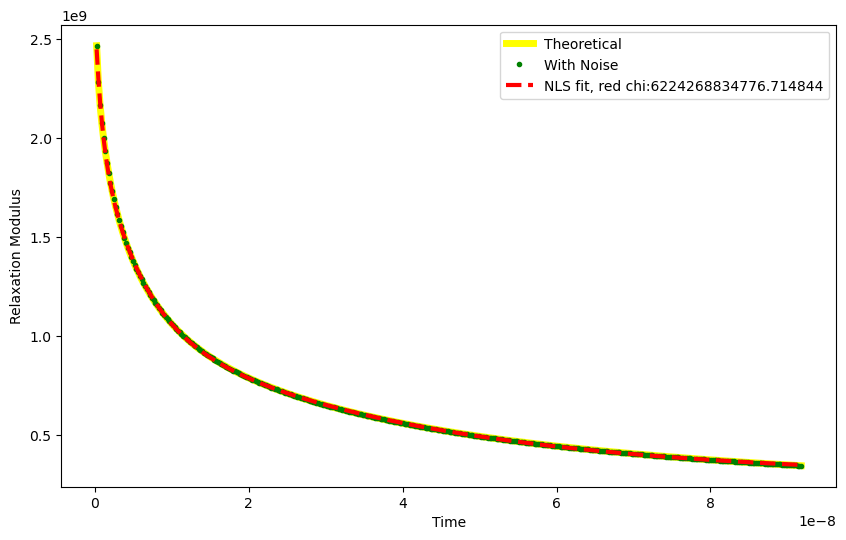

In [36]:
#evaluate Grel for fitted parameters
grel_fit, tn_fit =g_maxwell_finite(P,M,Delta_t,G_grel_c,tau_grel_c,Ge_grel_c)

# Plot the relaxation modulus with and without noise
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tn[1:M], y_n[1:M], label='Theoretical',color='yellow',lw=5)
ax.plot(tn[1:M], y_noisy[1:M], 'o',markersize=3, label='With Noise', color='green',lw=3)
ax.plot(tn_fit[1:M],grel_fit[1:M], label='NLS fit, red chi:%2.6f'%res_grel_c.redchi, color='red',linestyle='dashed',lw=3)
#ax.plot(tn, y_n, label='Theoretical',color='yellow',lw=5)
#ax.plot(tn, y_noisy, 'o',markersize=3, label='With Noise', color='green',lw=3)
#ax.plot(tn_fit,grel_fit, label='NLS fit', color='red',linestyle='dashed',lw=3)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('Relaxation Modulus')
ax.legend()
plt.show()

In [37]:
#g_nu,omega = perform_fft(y_noisy, Delta_t)  #numerical FFT of input
g_nu,omega = perform_fft(y_n2, Delta_t)  #numerical FFT of original input



ini_par_dtft = {
    'model': g_hat,
    'arms': 3,
    'Ge': 0.0,
    'G_i': [10.0e9,1.0e9,1.0e8],  # initial guesses for G1 to G3
    'tau_i': [Delta_t/10.0,Delta_t,Delta_t*10], # initial guesses for tau1 to tau3
    'delta_t':Delta_t,
    'M':M,
    'method_fit':'leastsq'
}


Ge_dtft_fit, tau_dtft_fit, G_dtft_fit, res_dtft_fit= nls_fit(omega[1:-1],g_nu[1:-1], **ini_par_dtft)

ini_par_ctft = {
    'model': g_hat_ctft,
    'arms': 3,
    'Ge': 0.0,
    'G_i': [10.0e9,1.0e9,1.0e8],  # initial guesses for G1 to G3
    'tau_i': [Delta_t/10.0,Delta_t,Delta_t*10], # initial guesses for tau1 to tau3
    'delta_t':Delta_t,
    'M':M,
    'method_fit':'leastsq'
}

Ge_ctft_fit, tau_ctft_fit, G_ctft_fit,res_ctft_fit= nls_fit(omega[1:-1],g_nu[1:-1], **ini_par_ctft)

In [38]:
print(Ge_dtft_fit, tau_dtft_fit, G_dtft_fit)

0.0 [2.33010692e-10 2.93131178e-09 1.72625666e-08] [6.33798017e+08 8.96884933e+08 1.08739853e+09]


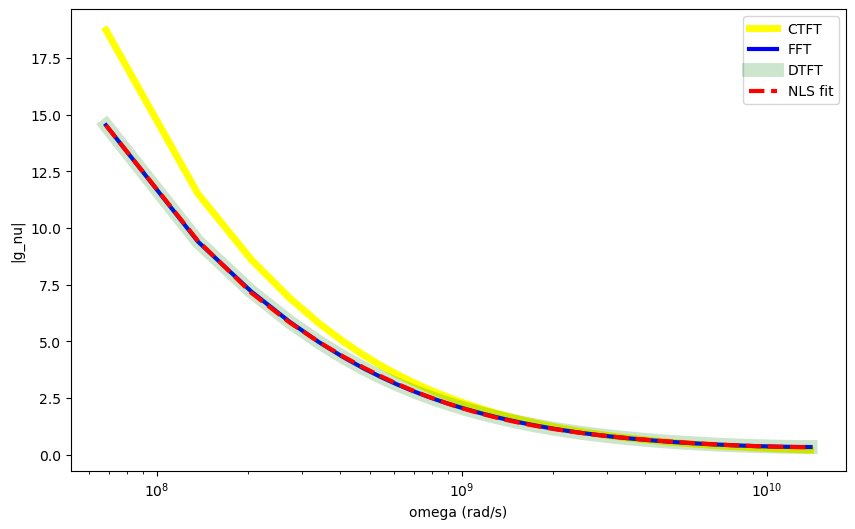

In [39]:
dtft_fit = dtft_gt_finite(omega[1::], Delta_t, G_dtft_fit, tau_dtft_fit, Ge_dtft_fit, M)  #theoretical DTFT with fitted params
dtft = dtft_gt_finite(omega[1::], Delta_t, G_k, tau_k, G_e, M)  #theoretical DTFT


simp = Y(omega[1::], Delta_t, G_k, tau_k, M)

aliased,leaked = X(omega[1::], Delta_t, G_k, tau_k, M, G_e) #theoretical aliased and leaked DTFTs
ctft = calculate_g_nu(G_e, G_k, tau_k, omega[1::]) #theoretical CTFT


#plot Fourier domain functions and fits
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega[1::],np.abs(ctft), label='CTFT', color='yellow',lw=5)
ax.plot(omega[1::],np.abs(g_nu[1::]), label='FFT',color='blue',lw=3)
ax.plot(omega[1::],np.abs(dtft), label='DTFT', color='green',lw=10,alpha=0.2)
#ax.plot(omega[1::],np.abs(dtft), label='DTFT-simp', color='black',lw=5,alpha=0.4)

#ax.plot(omega[1::],np.abs(aliased), label='DTFT aliased', color='orange',lw=3,alpha=0.5)
#ax.plot(omega[1::],np.abs(leaked), label='DTFT aliased-leaked', color='cyan',lw=3,alpha=0.6)

ax.plot(omega[1::],np.abs(dtft_fit), label='NLS fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('omega (rad/s)')
ax.set_ylabel('|g_nu|')
ax.legend()
plt.show()

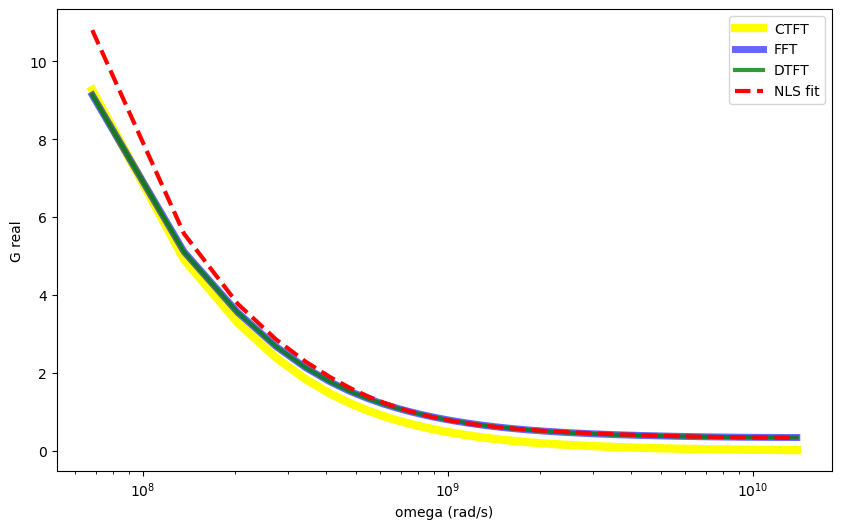

In [40]:
#plot the real part of the Fourier Domain
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega[1::],np.real(ctft), label='CTFT', color='yellow',lw=6)
ax.plot(omega[1::],np.real(g_nu[1::]), label='FFT',color='blue',lw=5,alpha=0.6)
ax.plot(omega[1::],np.real(dtft), label='DTFT', color='green',lw=3,alpha=0.8)
ax.plot(omega[1::],np.real(dtft_fit), label='NLS fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('omega (rad/s)')
ax.set_ylabel('G real')
ax.legend()
plt.show()

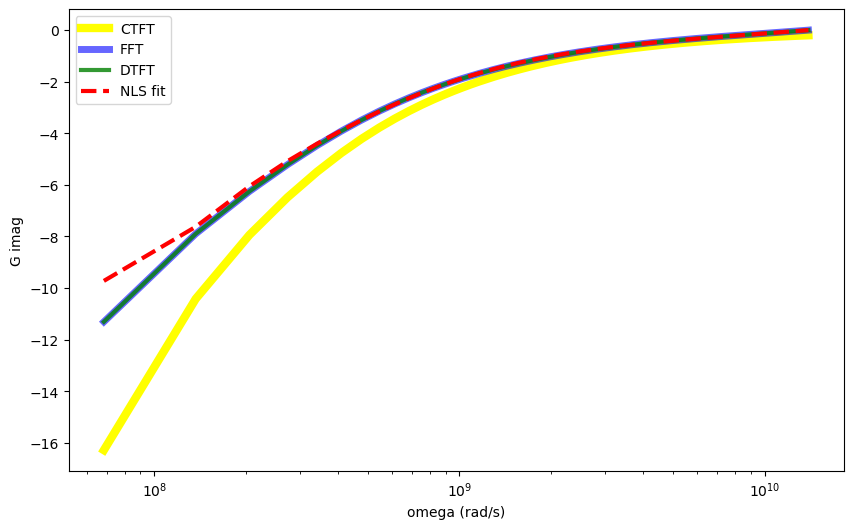

In [41]:
#plot the imag part of the Fourier Domain
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega[1::],np.imag(ctft), label='CTFT', color='yellow',lw=6)
ax.plot(omega[1::],np.imag(g_nu[1::]), label='FFT',color='blue',lw=5,alpha=0.6)
ax.plot(omega[1::],np.imag(dtft), label='DTFT', color='green',lw=3,alpha=0.8)
ax.plot(omega[1::],np.imag(dtft_fit), label='NLS fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('omega (rad/s)')
ax.set_ylabel('G imag')
ax.legend()
plt.show()

Calculating Complex Modulus for theoretical and fitted parameters

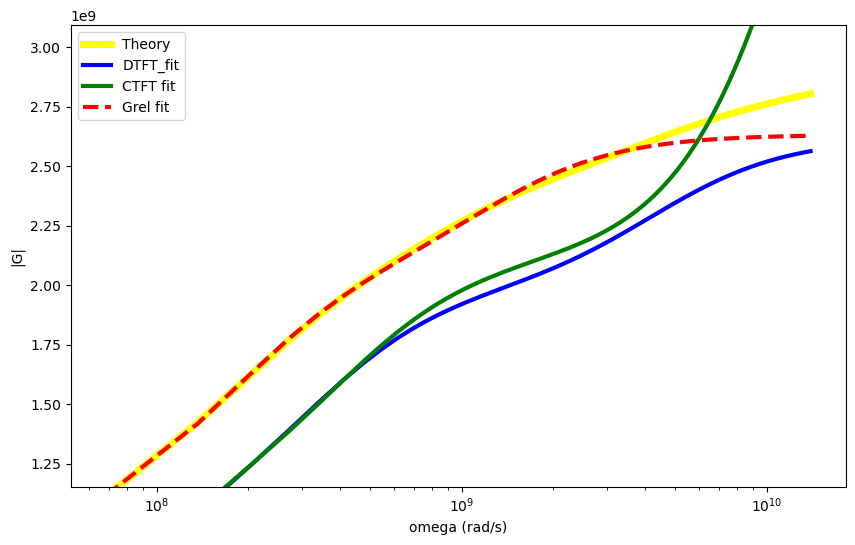

In [42]:
gstar_theory = g_star(omega[1::], G_e, G_k, tau_k)
gstar_dtft = g_star(omega[1::], Ge_dtft_fit, G_dtft_fit, tau_dtft_fit)
gstar_ctft = g_star(omega[1::], Ge_ctft_fit, G_ctft_fit, tau_ctft_fit)
gstar_grel = g_star(omega[1::], Ge_grel_c, G_grel_c, tau_grel_c)

#plot complex modulus
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega[1::],np.real(gstar_theory), label='Theory', color='yellow',lw=5)
ax.plot(omega[1::],np.real(gstar_dtft), label='DTFT_fit',color='blue',lw=3)
ax.plot(omega[1::],np.real(gstar_ctft), label='CTFT fit', color='green',lw=3)
ax.plot(omega[1::], np.real(gstar_grel), label='Grel fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(min(np.abs(gstar_theory))*0.9,max(np.abs(gstar_theory))*1.1)
ax.set_xlabel('omega (rad/s)')
ax.set_ylabel('|G|')
ax.legend()
plt.show()

In [14]:
print(res_dtft_fit.redchi)

5.769266493474412e-05


In [15]:
print(res_grel_c.redchi)

8721357471590.447


In [16]:
print(Ge_dtft_fit, G_dtft_fit, tau_dtft_fit)

0.0 [8.38006721e+08 9.22414594e+08 9.34292693e+08] [5.79365633e-10 4.47630112e-09 2.63386371e-08]


In [17]:
Delta_t*10.0

1.3636591185450299e-08